# Denoising mel-spectrograms with a residual dense network

## Setup

### Environment

In [2]:
!pip install -q ipython_secrets gsheet-keyring comet_ml

     |████████████████████████████████| 204kB 4.8MB/s 
     |████████████████████████████████| 419kB 10.3MB/s 
     |████████████████████████████████| 204kB 14.8MB/s 
     |████████████████████████████████| 2.7MB 14.2MB/s 
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.


In [2]:
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
[[ -d ./apex ]] || git clone https://github.com/NVIDIA/apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Overwriting setup.sh


In [3]:
!sh setup.sh

setup.sh: 3: setup.sh: [[: not found
fatal: destination path 'apex' already exists and is not an empty directory.


### Variables

In [1]:
from ipython_secrets import get_secret

CODEBASE = "https://github.com/sdll/audio-denoising"

PROJECT = "Arbeit"
COMET_ML_API_KEY = get_secret("comet-{}".format(PROJECT))

GDRIVE_MOUNT_POINT = "/content/drive"
TRAIN_DATASET = "dataset/train"
VAL_DATASET = "dataset/val"
WORKSPACE= "sdll"

from google.colab import drive
import os
drive.mount(GDRIVE_MOUNT_POINT)
GOOGLE_DRIVE_ROOT = GDRIVE_MOUNT_POINT + "/" + list(filter(lambda x: x[0] != '.', os.listdir(GDRIVE_MOUNT_POINT)))[0]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data

In [4]:
!git clone $CODEBASE

Cloning into 'audio-denoising'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 81 (delta 29), reused 66 (delta 17), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [5]:
%cd audio-denoising

/content/audio-denoising


In [6]:
!mkdir -p dataset

![[ -f ./dataset/train.zip ]] || wget https://www.dropbox.com/s/n6nhp5e231rl0b5/train.zip?raw=1 -O dataset/train.zip
![[ -f ./dataset/test.zip ]] || wget https://www.dropbox.com/s/nt4q2n0esiboc1i/val.zip?raw=1 -O dataset/val.zip

--2020-05-01 17:19:51--  https://www.dropbox.com/s/n6nhp5e231rl0b5/train.zip?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n6nhp5e231rl0b5/train.zip [following]
--2020-05-01 17:19:51--  https://www.dropbox.com/s/raw/n6nhp5e231rl0b5/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc273db9627f344ccada144f837.dl.dropboxusercontent.com/cd/0/inline/A27sGoGT7LJaaJzPdDcix68Psdl7FY0LghcDGg3GkOjvgzQgfZ_qzSjJWvKRp53quoh8D0hkOD8g42hlGdLYErihB--2VaKhoZbKAxDPg4xEkPe7Ua5rOSWaVBZosMSvKzY/file# [following]
--2020-05-01 17:19:52--  https://ucc273db9627f344ccada144f837.dl.dropboxusercontent.com/cd/0/inline/A27sGoGT7LJaaJzPdDcix68Psdl7FY0LghcDGg3GkOjvgzQgfZ_qzSjJWvKRp53quoh8D0hkOD8g42hlGdLYErihB--2VaKhoZbKAxDPg4xEkPe7Ua5rO

In [7]:
%cd dataset
![[ -d train ]] || unzip -qq train.zip
![[ -d val ]] || unzip -qq val.zip
%cd ..

/content/audio-denoising/dataset
/content/audio-denoising


In [0]:
![[ -d pytorch_ssim ]] || (git clone https://github.com/Po-Hsun-Su/pytorch-ssim && mv pytorch-ssim/pytorch_ssim . && rm -rf pytorch-ssim)

### Imports

In [2]:
%cd /content/audio-denoising/
from comet_ml import Experiment

import argparse
from timeit import default_timer as timer

import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch import nn, optim
from tqdm import tqdm as tqdm_base

from audio_denoising.data.loader import load
from audio_denoising.model.rdn import ResidualDenseNetwork as Model
from pytorch_ssim import ssim


def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, "_instances"):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

/content/audio-denoising


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from apex import amp, optimizers

In [0]:
sns.set()

## Training

In [0]:
def get_arg_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument("--batch-size", type=int, default=8)
    parser.add_argument("--growth-rate", type=int, default=16)
    parser.add_argument("--kernel-size", type=int, default=3)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--num-blocks", type=int, default=20)
    parser.add_argument("--num-channels", type=int, default=1)
    parser.add_argument("--num-epochs", type=int, default=80)
    parser.add_argument("--num-features", type=int, default=16)
    parser.add_argument("--num-layers", type=int, default=6)
    parser.add_argument("--seed", type=int, default=42)

    return parser


def get_criterion():
    return nn.MSELoss()


def get_optimizer(model, lr=1e-3):
    return optimizers.FusedAdam(model.parameters(), lr)
    # return optim.SGD(model.parameters(), lr)


def psnr(prediction, target, max_pixel=255.0):
    return 10.0 * ((max_pixel ** 2) / ((prediction - target) ** 2).mean()).log10()


def train(
    experiment,
    loader,
    model,
    criterion,
    optimizer,
    args,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    scheduler=None,
    validator=None,  # (validate, val_loader)
    verbose=True,
):
    experiment.log_parameters(vars(args))

    np.random.seed(args.seed)

    # save the model weights with the best psnr
    if validator:
        best_psnr = 0.0

    for epoch in tqdm(range(args.num_epochs), desc="Epoch", unit="epochs"):
        with experiment.train():
            model.train()
            train_psnr = []
            train_ssim = []

            for clean_image, noisy_image in tqdm(
                loader, desc="Train images", unit="batches"
            ):
                image = noisy_image.to(device, dtype=torch.float)
                gt_image = clean_image.to(device, dtype=torch.float)
                noise = image - gt_image

                prediction = model(image)
                cleaned_image = image - prediction

                loss = criterion(prediction, noise)

                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()

                optimizer.step()
                optimizer.zero_grad()

                current_psnr = psnr(cleaned_image, gt_image).data.item()
                current_ssim = ssim(cleaned_image, gt_image).data.item()
                train_psnr.append(current_psnr)
                train_ssim.append(current_ssim)
                experiment.log_metric("psnr", current_psnr)
                experiment.log_metric("ssim", current_ssim)
                experiment.log_metric("loss", scaled_loss.data.item())

            experiment.log_metric("mean_psnr", np.mean(train_psnr))
            experiment.log_metric("mean_ssim", np.mean(train_ssim))
        if validator:
            validate, val_loader = validator
            test_psnr, _, _ = validate(experiment, val_loader, model, device, verbose)
            if scheduler:
                scheduler.step(test_psnr)
            if test_psnr > best_psnr:
                best_psnr = test_psnr
                filename_pth = GOOGLE_DRIVE_ROOT + '/audio_denoising_psnr_{:.4f}_epoch_{}_D_{}_C_{}_G_{}_G0_{}.pth'.format(
                    test_psnr, epoch, args.num_blocks, args.num_layers, args.growth_rate, args.num_features
                )
                torch.save(model.state_dict(), filename_pth)
    return model


def validate(
    experiment,
    loader,
    model,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    verbose=True,
):
    with experiment.test():
        model.eval()
        test_psnr = []
        test_ssim = []
        test_prediction_times = []
        for clean_image, noisy_image in tqdm(loader, desc="Val images", unit="batches"):
            image = noisy_image.to(device, dtype=torch.float)
            gt_image = clean_image.to(device, dtype=torch.float)
            start = timer()
            prediction = model(image)
            end = timer()
            cleaned_image = image - prediction

            prediction_time = end - start
            test_prediction_times.append(prediction_time)
            experiment.log_metric("prediction_time", prediction_time)

            current_psnr = psnr(cleaned_image, gt_image).data.item()
            current_ssim = ssim(cleaned_image, gt_image).data.item()

            test_psnr.append(current_psnr)
            test_ssim.append(current_ssim)

        test_psnr = np.mean(test_psnr)
        test_ssim = np.mean(test_ssim)
        test_prediction_time = np.mean(test_prediction_times)

        experiment.log_metric("mean_psnr", test_psnr)
        experiment.log_metric("mean_ssim", test_ssim)
        experiment.log_metric("mean_prediction_time", test_prediction_time)

    if verbose:
        print(
            "\nMean Test PSNR: {:.2f}\nMean Test SSIM: {:.2f}\nMean Prediction Time: {:.2f}".format(
                test_psnr, test_ssim, test_prediction_time
            )
        )
    return test_psnr, test_ssim, test_prediction_time

In [4]:
experiment = Experiment(
    api_key=COMET_ML_API_KEY,
    project_name=PROJECT,
    workspace=WORKSPACE,
    auto_output_logging=None,
)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sdll/arbeit/95dc16e2efd644f3a887cb57425cce08



In [0]:
args = get_arg_parser().parse_args(args=[])

train_loader = load(TRAIN_DATASET, batch_size=args.batch_size)
val_loader = load(VAL_DATASET, batch_size=1)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(args).to(device)

In [0]:
optimizer = get_optimizer(model, args.lr)
model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
criterion = get_criterion()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=0, verbose=True)

In [0]:
train(
    experiment,
    train_loader,
    model,
    criterion,
    optimizer,
    args,
    device,
    scheduler=scheduler,
    validator=(validate, val_loader)
)

Epoch:   1%|▏         | 1/80 [19:32<25:43:24, 1172.21s/epochs]


Mean Test PSNR: 62.47
Mean Test SSIM: 0.55
Mean Prediction Time: 0.03


Train images:  97%|█████████▋| 1450/1500 [17:30<00:32,  1.52batches/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


Epoch:   2%|▎         | 2/80 [39:14<25:27:52, 1175.29s/epochs]


Mean Test PSNR: 63.01
Mean Test SSIM: 0.57
Mean Prediction Time: 0.03


Train images:   0%|          | 0/1500 [00:00<?, ?batches/s]


Mean Test PSNR: 62.91
Mean Test SSIM: 0.60
Mean Prediction Time: 0.03
Epoch     3: reducing learning rate of group 0 to 7.5000e-04.


Epoch:   5%|▌         | 4/80 [1:18:48<24:55:03, 1180.31s/epochs]


Mean Test PSNR: 63.63
Mean Test SSIM: 0.62
Mean Prediction Time: 0.03


Train images:  70%|██████▉   | 1044/1500 [12:25<04:59,  1.52batches/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


Epoch:   6%|▋         | 5/80 [1:38:30<24:35:53, 1180.72s/epochs]


Mean Test PSNR: 63.85
Mean Test SSIM: 0.62
Mean Prediction Time: 0.03


Epoch:   8%|▊         | 6/80 [1:57:50<24:08:30, 1174.47s/epochs]


Mean Test PSNR: 63.93
Mean Test SSIM: 0.61
Mean Prediction Time: 0.04


Train images:  11%|█▏        | 172/1500 [02:12<14:17,  1.55batches/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


Epoch:   9%|▉         | 7/80 [2:17:29<23:50:33, 1175.80s/epochs]


Mean Test PSNR: 64.07
Mean Test SSIM: 0.62
Mean Prediction Time: 0.03


Train images:  65%|██████▍   | 970/1500 [11:38<07:15,  1.22batches/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


Train images:   0%|          | 0/1500 [00:00<?, ?batches/s]


Mean Test PSNR: 63.10
Mean Test SSIM: 0.61
Mean Prediction Time: 0.03
Epoch     8: reducing learning rate of group 0 to 5.6250e-04.


Train images:  69%|██████▉   | 1041/1500 [12:25<05:11,  1.48batches/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


Epoch:  11%|█▏        | 9/80 [2:56:31<23:08:38, 1173.51s/epochs]


Mean Test PSNR: 64.55
Mean Test SSIM: 0.64
Mean Prediction Time: 0.03


Epoch:  12%|█▎        | 10/80 [3:15:56<22:46:08, 1170.98s/epochs]


Mean Test PSNR: 64.62
Mean Test SSIM: 0.63
Mean Prediction Time: 0.03


Epoch:  14%|█▍        | 11/80 [3:35:36<22:29:45, 1173.71s/epochs]


Mean Test PSNR: 64.72
Mean Test SSIM: 0.65
Mean Prediction Time: 0.03


Train images:  37%|███▋      | 561/1500 [06:39<09:51,  1.59batches/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


Train images:  83%|████████▎ | 1249/1500 [15:07<02:53,  1.45batches/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


Train images:   0%|          | 0/1500 [00:00<?, ?batches/s]


Mean Test PSNR: 64.65
Mean Test SSIM: 0.65
Mean Prediction Time: 0.03
Epoch    12: reducing learning rate of group 0 to 4.2188e-04.


Epoch:  16%|█▋        | 13/80 [4:15:02<21:55:35, 1178.14s/epochs]


Mean Test PSNR: 64.89
Mean Test SSIM: 0.65
Mean Prediction Time: 0.03


Train images:  56%|█████▌    | 841/1500 [10:24<06:02,  1.82batches/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


Train images:   0%|          | 0/1500 [00:00<?, ?batches/s]


Mean Test PSNR: 64.44
Mean Test SSIM: 0.64
Mean Prediction Time: 0.03
Epoch    14: reducing learning rate of group 0 to 3.1641e-04.


Epoch:  19%|█▉        | 15/80 [4:54:32<21:19:19, 1180.91s/epochs]


Mean Test PSNR: 65.14
Mean Test SSIM: 0.66
Mean Prediction Time: 0.03


Val images:  88%|████████▊ | 1767/2000 [01:26<00:11, 19.74batches/s]

The Comet logs of this round of training can be found [here](https://www.comet.ml/sdll/arbeit/a40a28c88443436984eedc52913c3a09).

In [0]:
filename_pth = GOOGLE_DRIVE_ROOT + '/audio_denoising_psnr_{:.4f}_epoch_{}.pth'.format(
    59.71, 35 
)
torch.save(model.state_dict(), filename_pth)

## Validation

In [5]:
# ckpt = GOOGLE_DRIVE_ROOT + '/audio_denoising_psnr_59.7472_epoch_6.pth'
ckpt = GOOGLE_DRIVE_ROOT + "/audio_denoising_psnr_65.1736_epoch_15_D_20_C_6_G_16_G0_16.pth"
model.load_state_dict(torch.load(ckpt))

<All keys matched successfully>

In [7]:
test_psnr, test_ssim, test_prediction_time = validate(experiment, val_loader, model, verbose=True)


Val images: 100%|██████████| 2000/2000 [01:36<00:00, 20.72batches/s]


Mean Test PSNR: 65.17
Mean Test SSIM: 0.66
Mean Prediction Time: 0.02


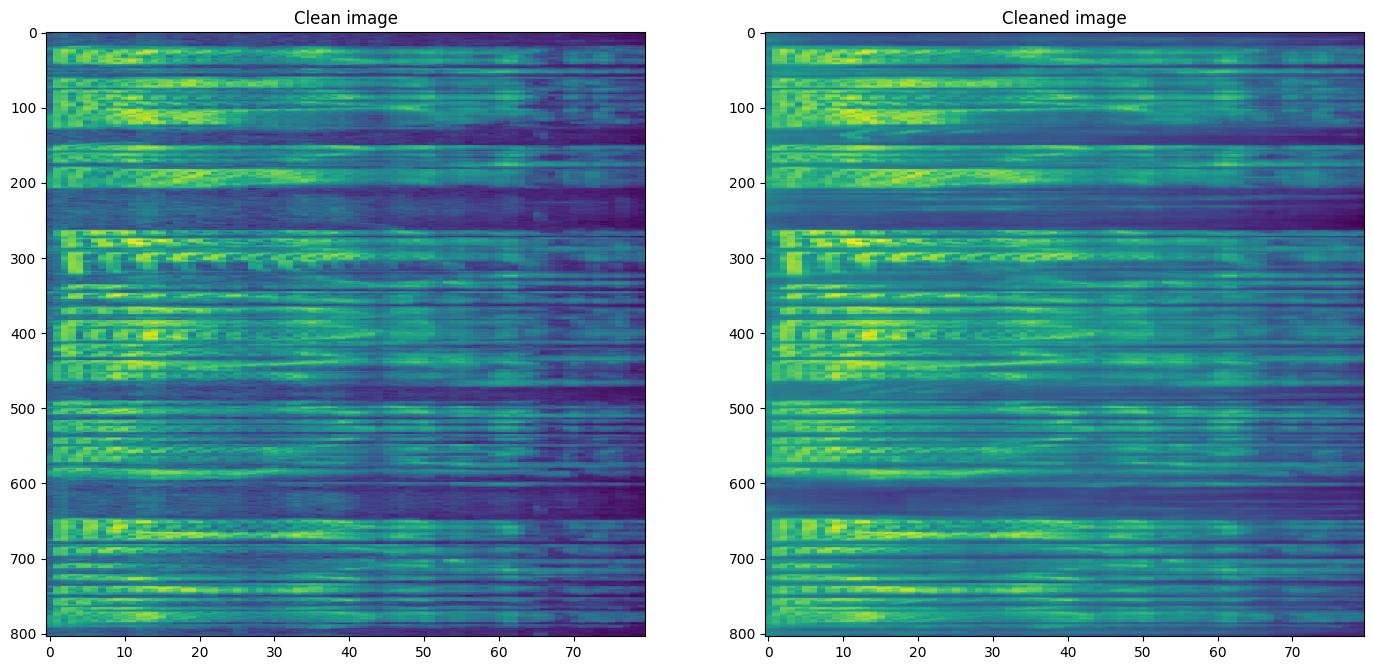

In [8]:
%matplotlib inline
from IPython.display import clear_output, display
import sys
import time
for clean_mel, noisy_mel in val_loader: 
    time.sleep(.25)
    clean_mel = clean_mel.to("cpu", dtype=torch.float)
    noisy_mel = noisy_mel.to("cpu", dtype=torch.float)
    fig = plt.figure(figsize=(17, 8), dpi=100)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(clean_mel.squeeze(), interpolation='nearest', aspect='auto')
    ax1.set_title('Clean image')
    ax2.imshow((noisy_mel - model(noisy_mel.to(device)).data.to("cpu")).squeeze(),
               interpolation='nearest', aspect='auto')
    ax2.set_title('Cleaned image')
    display(fig)
    clear_output(wait=True)
    sys.stdout.flush()
    break


## SSIM Inference Analysis

In [0]:
from audio_denoising.data.loader import SpectogramDataset
clean_dataset = SpectogramDataset(VAL_DATASET + "/clean")
noisy_dataset = SpectogramDataset(VAL_DATASET + "/noisy")

In [0]:
def compute_ssims(dataset):
    ssims = []
    for file_idx in tqdm(range(len(dataset)), unit="files"):
        img = dataset[file_idx].unsqueeze(0).to(device, dtype=torch.float)
        noise = model(img).to("cpu")
        img = img.to("cpu")
        ssims.append(ssim(img - noise, img).data.item())
    return ssims

In [8]:
clean_ssims = compute_ssims(clean_dataset)

100%|██████████| 2000/2000 [02:52<00:00, 11.62files/s]


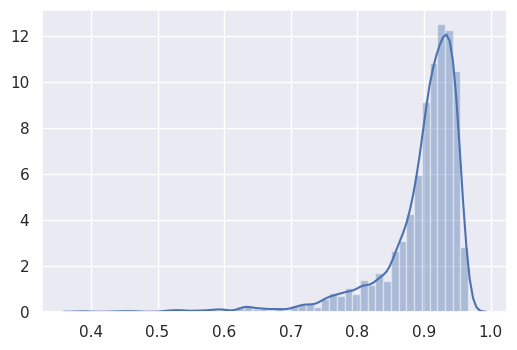

In [13]:
plt.figure(dpi=100)
sns.distplot(clean_ssims)
plt.show()

In [9]:
noisy_ssims = compute_ssims(noisy_dataset)

100%|██████████| 2000/2000 [02:51<00:00, 11.69files/s]


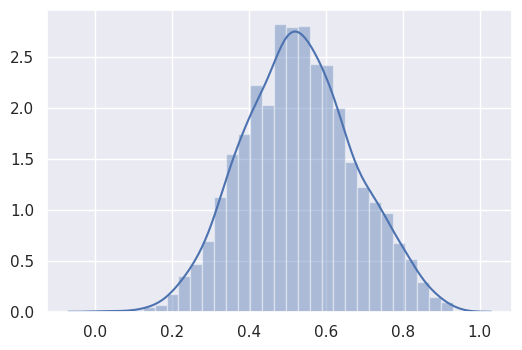

In [14]:
plt.figure(dpi=100)
sns.distplot(noisy_ssims)
plt.show()

In [0]:
clean_ssims = np.asarray(clean_ssims)
noisy_ssims = np.asarray(noisy_ssims)
threshold = 0.77
true_clean = np.sum(clean_ssims > threshold) / len(clean_ssims)
true_noisy = np.sum(noisy_ssims < threshold) / len(noisy_ssims)

In [21]:
print("True clean ratio: {}".format(true_clean))
print("True noisy ratio: {}".format(true_noisy))

True clean ratio: 0.95
True noisy ratio: 0.9425


## Scratchpad

In [0]:
dataset = load(TRAIN_DATASET, batch_size=1)
heights = []
for clean_mel, noisy_mel in dataset:
    heights.append(clean_mel.shape[2]) 

In [0]:
plt.figure(dpi=120)
plt.title("Distribution of Train MEL Heights")
plt.xlabel("Height, px")
plt.ylabel("Frequency")
sns.distplot(heights)
plt.show()

In [0]:
min(heights), max(heights)

In [8]:
%cd /content/audio-denoising/
!git pull

/content/audio-denoising
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5 (delta 3), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/sdll/audio-denoising
   e6cfe55..a265561  master     -> origin/master
Updating e6cfe55..a265561
Fast-forward
 audio_denoising/model/rdn.py | 6 ------
 1 file changed, 6 deletions(-)


In [0]:
%%capture
args = get_arg_parser().parse_args(args=[])

train_loader = load(TRAIN_DATASET, batch_size=args.batch_size)
val_loader = load(VAL_DATASET, batch_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

experiment = Experiment(
    api_key=COMET_ML_API_KEY,
    project_name=PROJECT,
    workspace=WORKSPACE,
    auto_output_logging=None,
)

grid_search = {
    "num_blocks": np.arange(3, 12, 3),
    "num_layers": np.arange(6, 18, 3),
    "num_features": np.arange(8, 32, 8),
    "growth_rate": np.arange(8, 32, 8),
}

best = {
    "num_blocks": None,
    "num_layers": None,
    "num_features": None,
    "growth_rate": None,
}

args.num_epochs = 2

best_psnr = 0.0
for num_blocks in grid_search["num_blocks"]:
    for num_layers in grid_search["num_layers"]:
        for num_features in grid_search["num_features"]:
            for growth_rate in grid_search["growth_rate"]:
                setattr(args, "num_blocks", num_blocks)
                setattr(args, "num_layers", num_layers)
                setattr(args, "num_features", num_features)
                setattr(args, "growth_rate", growth_rate)
                model = Model(args).to(device)
                optimizer = get_optimizer(model, args.lr)
                model, optimizer = amp.initialize(model, optimizer, opt_level="O3")
                criterion = get_criterion()
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, mode="max", factor=0.75, patience=0, verbose=True
                )
                train(
                    experiment,
                    [next(iter(train_loader))],
                    model,
                    criterion,
                    optimizer,
                    args,
                    device,
                    scheduler=scheduler,
                )
                test_psnr, _, _ = validate(
                    experiment, [next(iter(val_loader))], model, device, verbose=False
                )
                if test_psnr > best_psnr:
                    best_psnr = test_psnr
                    best["num_blocks"] = num_blocks
                    best["num_layers"] = num_layers
                    best["num_features"] = num_features
                    best["growth_rate"] = growth_rate
                del model, optimizer, criterion, scheduler
                torch.cuda.empty_cache()
experiment.end()


In [0]:
print(best)

In [0]:
while True:
    pass

In [0]:
next(iter(val_loader))